In [1]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import numpy as np
from matplotlib import pyplot as plt

# Prepare data

In [2]:
data = load_iris()

In [3]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(data.data)

In [4]:
ohe = OneHotEncoder(categories='auto', sparse=False)
y = ohe.fit_transform(data.target.reshape(-1, 1))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Model builder

In [6]:
def get_model(inp_shape, out_shape, optimizer=None):
    model = Sequential()
    model.add(Dense(8, activation='relu', input_shape = (inp_shape,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(out_shape, activation='softmax'))
    if optimizer is None:
        model.compile(loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
    else:
        model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
    return model

# Helper functions

In [7]:
def init_weights(model, std = 0.1):
    for layer in model.layers:
        layer.set_weights([np.random.normal(0, std, size = layer.get_weights()[0].shape), 
                           np.random.normal(0, std, size = layer.get_weights()[1].shape)])

In [8]:
def get_weights(model):
    weights = []
    for layer in model.layers:
        weights.append(layer.get_weights())
    return weights

In [9]:
def set_weights(model, weights):
    for layer, weights_i in zip(model.layers, weights):
        layer.set_weights(weights_i)

In [10]:
def sample_weights_of_layer(layer, std = 0.1):
    new_weights = [np.zeros(layer.get_weights()[0].shape), 
                   np.zeros(layer.get_weights()[1].shape)]
    
    for i, row in enumerate(layer.get_weights()[0]):
        for j, weight in enumerate(row):
            new_weights[0][i][j] = np.random.normal(weight, std)
    for i, weight in enumerate(layer.get_weights()[1]):
        new_weights[1][i] = np.random.normal(weight, std)
            
    layer.set_weights(new_weights)

In [11]:
def sample_weights(model, std = 0.1):
    for layer in model.layers:
        sample_weights_of_layer(layer, std)

In [12]:
def is_accept(old_loss, new_loss, T):
    ar = np.exp(-new_loss / T) / np.exp(-old_loss / T)
    return np.random.uniform() <= ar

In [13]:
def draw_metrics(losses, val_losses, accs, val_accs, losses_title='Losses', accs_title='Accuracies'):
    plt.rcParams["figure.figsize"] = (20,6)
    
    iters = np.arange(len(losses))
    
    plt.subplot(1, 2, 1)
    plt.plot(iters, losses, label='loss')
    plt.plot(iters, val_losses, label='val_loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title(losses_title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iters, accs, label='acc')
    plt.plot(iters, val_accs, label='val_acc')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title(accs_title)
    plt.legend()
    plt.show()

# Simulated annealing optimizer

In [14]:
def sa_optimize(model, X, y, T = 2, min_T = 0.003, annealing_rate = 0.99, annealing_iterations = 1, std = 0.2):
    
    init_weights(model)
    
    losses = []
    accs = []
    val_losses = []
    val_accs = []
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    it = 0
    
    while (T > min_T): 
        old_weights = get_weights(model)
        
        old_loss, old_acc = model.evaluate(X_train, y_train, verbose=False)
        sample_weights(model, std)
        loss, acc = model.evaluate(X_train, y_train, verbose=False)
        if not is_accept(old_loss, loss, T):
            set_weights(model, old_weights)
            loss, acc = old_loss, old_acc
            
        it += 1
        if it % annealing_iterations == 0:
            T *= annealing_rate       
        
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=False)
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        from IPython.display import clear_output
        clear_output(wait=True)
        draw_metrics(losses, val_losses, accs, val_accs, f'T = {T}', f'T = {T}')

# Train and evaluate model using SA optimizer

In [15]:
model = get_model(X.shape[1], y.shape[1])

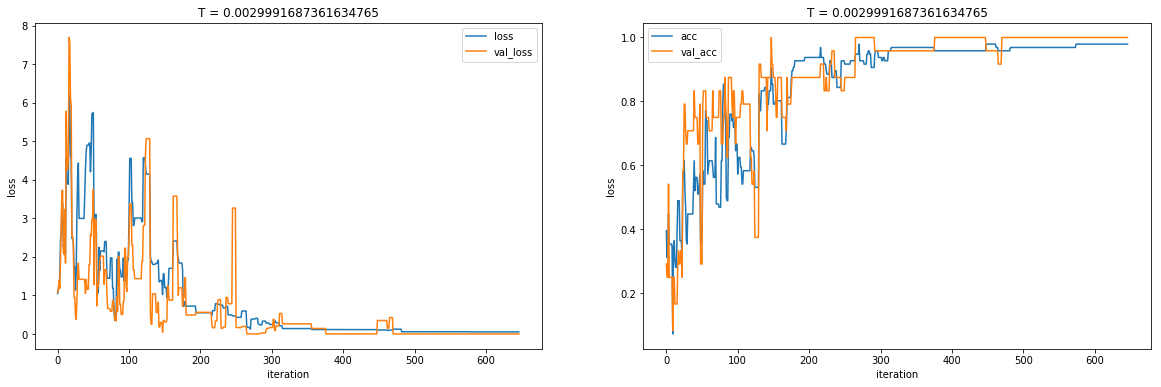

Annealing rate: 0.99
Test loss: 0.32541602849960327
Test accuracy: 0.8999999761581421
Wall time: 4min 19s


In [16]:
%%time
annealing_rate = 0.99
sa_optimize(model, X_train, y_train, annealing_rate=annealing_rate)
loss, acc = model.evaluate(X_test, y_test, verbose=False)
print(f'Annealing rate: {annealing_rate}\nTest loss: {loss}\nTest accuracy: {acc}')

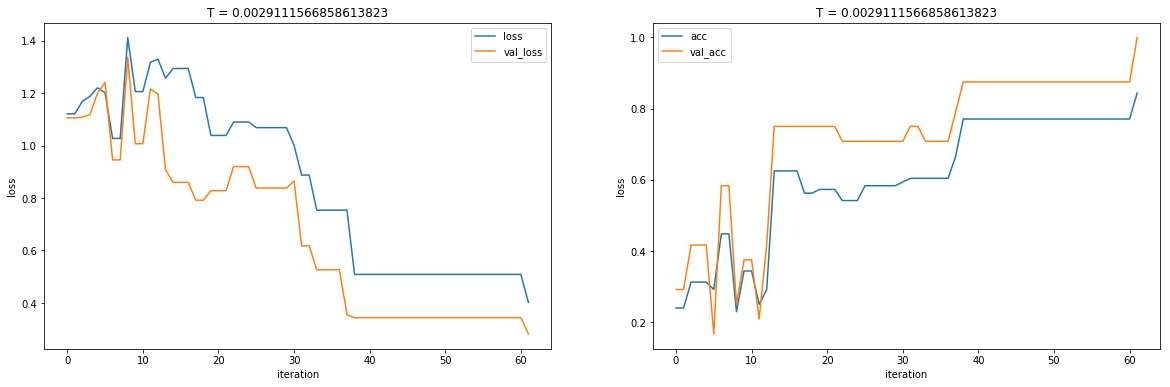

Annealing rate: 0.9
Test loss: 0.4155096709728241
Test accuracy: 0.800000011920929
Wall time: 26.2 s


In [17]:
%%time
annealing_rate = 0.9
sa_optimize(model, X_train, y_train, annealing_rate=annealing_rate)
loss, acc = model.evaluate(X_test, y_test, verbose=False)
print(f'Annealing rate: {annealing_rate}\nTest loss: {loss}\nTest accuracy: {acc}')

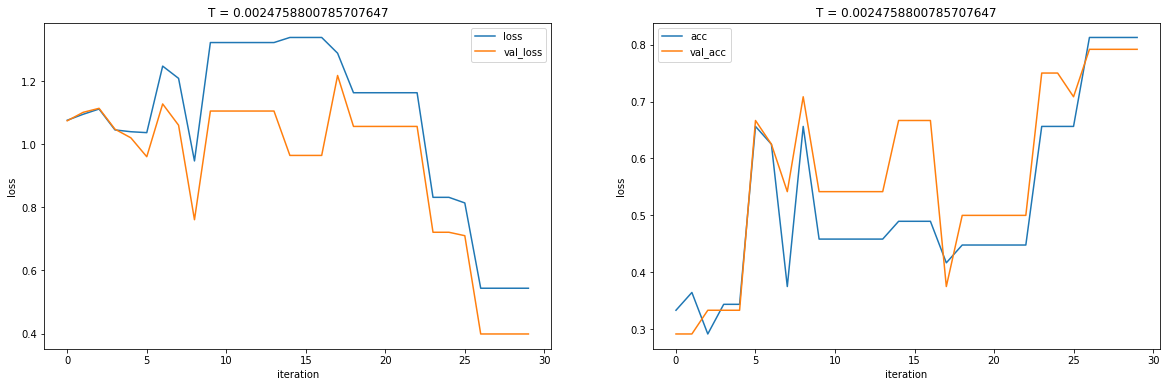

Annealing rate: 0.8
Test loss: 0.7685469388961792
Test accuracy: 0.800000011920929
Wall time: 11 s


In [21]:
%%time
annealing_rate = 0.8
sa_optimize(model, X_train, y_train, annealing_rate=annealing_rate)
loss, acc = model.evaluate(X_test, y_test, verbose=False)
print(f'Annealing rate: {annealing_rate}\nTest loss: {loss}\nTest accuracy: {acc}')

# SGD optimizer

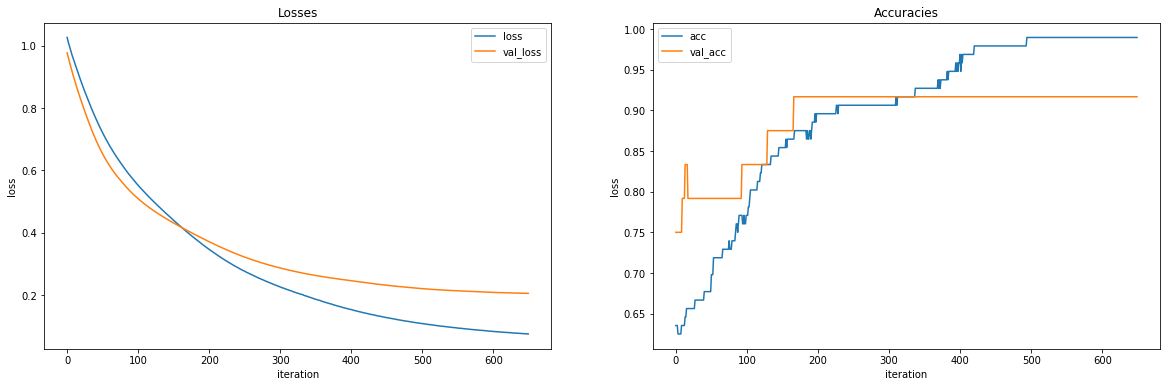

Test loss: 0.19467850029468536
Test accuracy: 0.8666666746139526
Wall time: 11.1 s


In [22]:
%%time
model = get_model(X.shape[1], y.shape[1], 'sgd')
history = model.fit(X_train, y_train, epochs=650, validation_split=0.2, verbose=False)
draw_metrics(history.history['loss'], history.history['val_loss'], 
             history.history['categorical_accuracy'], history.history['val_categorical_accuracy'])
loss, acc = model.evaluate(X_test, y_test, verbose=False)
print(f'Test loss: {loss}\nTest accuracy: {acc}')

# Adam optimizer

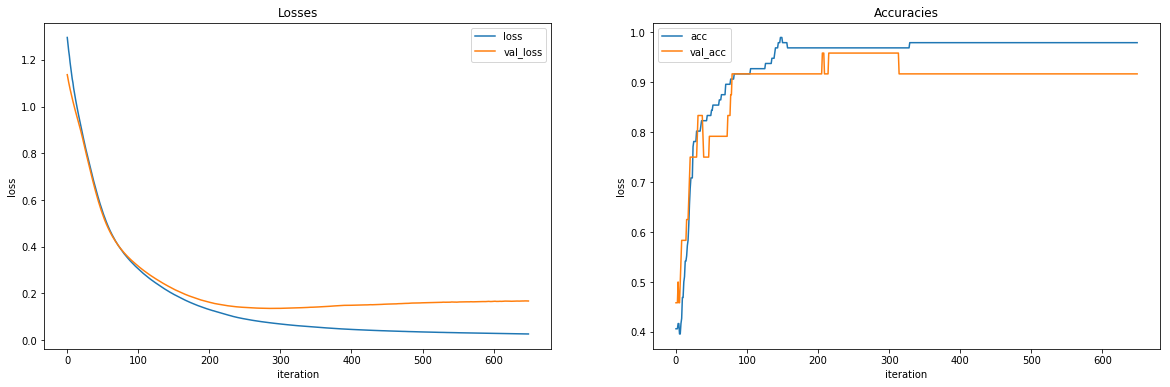

Test loss: 0.25566354393959045
Test accuracy: 0.9333333373069763
Wall time: 11.2 s


In [23]:
%%time
model = get_model(X.shape[1], y.shape[1], 'adam')
history = model.fit(X_train, y_train, epochs=650, validation_split=0.2, verbose=False)
draw_metrics(history.history['loss'], history.history['val_loss'], 
             history.history['categorical_accuracy'], history.history['val_categorical_accuracy'])
loss, acc = model.evaluate(X_test, y_test, verbose=False)
print(f'Test loss: {loss}\nTest accuracy: {acc}')